In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from project_utils import *
from pygsp import graphs, filters
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

%load_ext autoreload
%autoreload 2

In [2]:
FIGSIZE = (10, 15)
FIGSIZESUB = (25, 15)

In [3]:
# Load data and graph
seed = 42
actors_agg_adj = np.load("sparse_agg_actor_adj.npy")
actors_agg_df = pd.read_pickle("actors_agg_df.pkl")
actors_graph = nx.from_numpy_matrix(actors_agg_adj)
G = graphs.Graph(actors_agg_adj)
G.set_coordinates(kind="spring",seed=seed)

In [4]:
# Laplacian and spectral decomposition
G.compute_laplacian('combinatorial')
laplacian = G.L.toarray()
lam, U = np.linalg.eig(laplacian)

In [5]:
# Create ideal high-pass filter
ideal_hp = np.ones((actors_agg_adj.shape[0],))
ideal_hp[lam <= 1] = 0  # High-pass filter with cut-off at lambda=0.1

# Create ideal low-pass filter
ideal_lp = np.ones((actors_agg_adj.shape[0],))
ideal_lp[lam >= 0.1] = 0  # Low-pass filter with cut-off at lambda=0.1

# Create ideal band-pass filter
ideal_bp = np.ones((actors_agg_adj.shape[0],))
ideal_bp[lam < 0.1] = 0  # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
ideal_bp[lam > 0.5] = 0

# Create ideal Tikhonov filter
alpha = 0.99 / np.max(lam)
ideal_tk = np.ones((actors_agg_adj.shape[0],))
ideal_tk = 1 / (1 + alpha * lam)

In [6]:
# Create polynomial graph filter with given order
def graph_filter(order, ideal):
    coeff = fit_polynomial(lam, order, ideal)
    return polynomial_graph_filter(coeff, laplacian)

In [7]:
# Create polynomial graph filters
order = 3
g_f_hp = graph_filter(order, ideal_hp) # High-pass
g_f_lp = graph_filter(order, ideal_lp) # Low-pass
g_f_bp = graph_filter(order, ideal_bp) # Band-pass
g_f_tk = graph_filter(order, ideal_tk) # Tikhonov

In [8]:
def apply_filter_and_add_communities(graph_filter):
    # Get only continous features
    continuous_features = actors_agg_df.filter(["budget", "revenue", "vote_average", "popularity"]).to_numpy()
    # Apply filter
    x_filtered = graph_filter @ continuous_features
    x_filtered_df = pd.DataFrame(data=x_filtered, columns=["budget", "revenue", "vote_average", "popularity"])
    # Update dataframe with new filtered columns
    new_df = actors_agg_df.copy()
    new_df.update(x_filtered_df)
    # Add communities column
    communities_df = pd.DataFrame(data=actors_with_comunities_dataset[:,-1], columns=["community"])
    communities_df["community"] = communities_df["community"].apply(np.int)
    new_df = new_df.merge(communities_df, left_index=True, right_index=True)
    return new_df

In [9]:
actors_with_comunities_dataset = np.load("actors_with_communities_dataset.npy")
# Apply filter, get new dataframes
hp_new_df = apply_filter_and_add_communities(g_f_hp) # high-pass filter new dataframe
lp_new_df = apply_filter_and_add_communities(g_f_lp) # low-pass filter new dataframe
bp_new_df = apply_filter_and_add_communities(g_f_bp) # band-pass filter new dataframe
tk_new_df = apply_filter_and_add_communities(g_f_tk) # Tikhonov filter new dataframe

In [10]:
cols = ["budget", "revenue", "vote_average", "popularity","community"]

In [11]:
hp_new_df = hp_new_df[cols]
lp_new_df = lp_new_df[cols]
bp_new_df = bp_new_df[cols]
tk_new_df = tk_new_df[cols]

/home/arielalba/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:
/home/arielalba/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:
/home/arielalba/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:
/home/arielalba/miniconda3/envs/ntds_2019/lib/python3.7/si

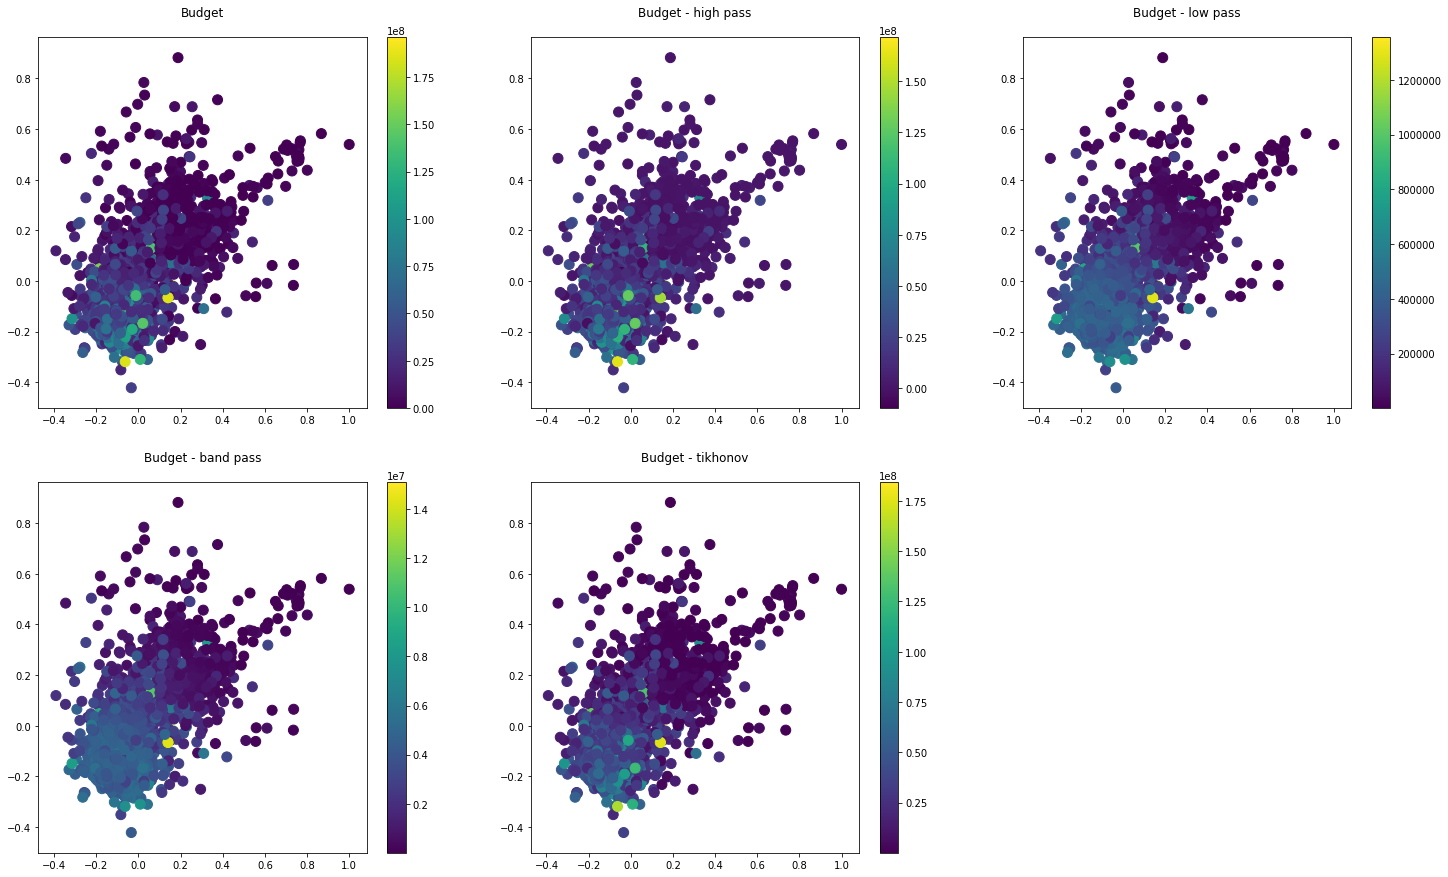

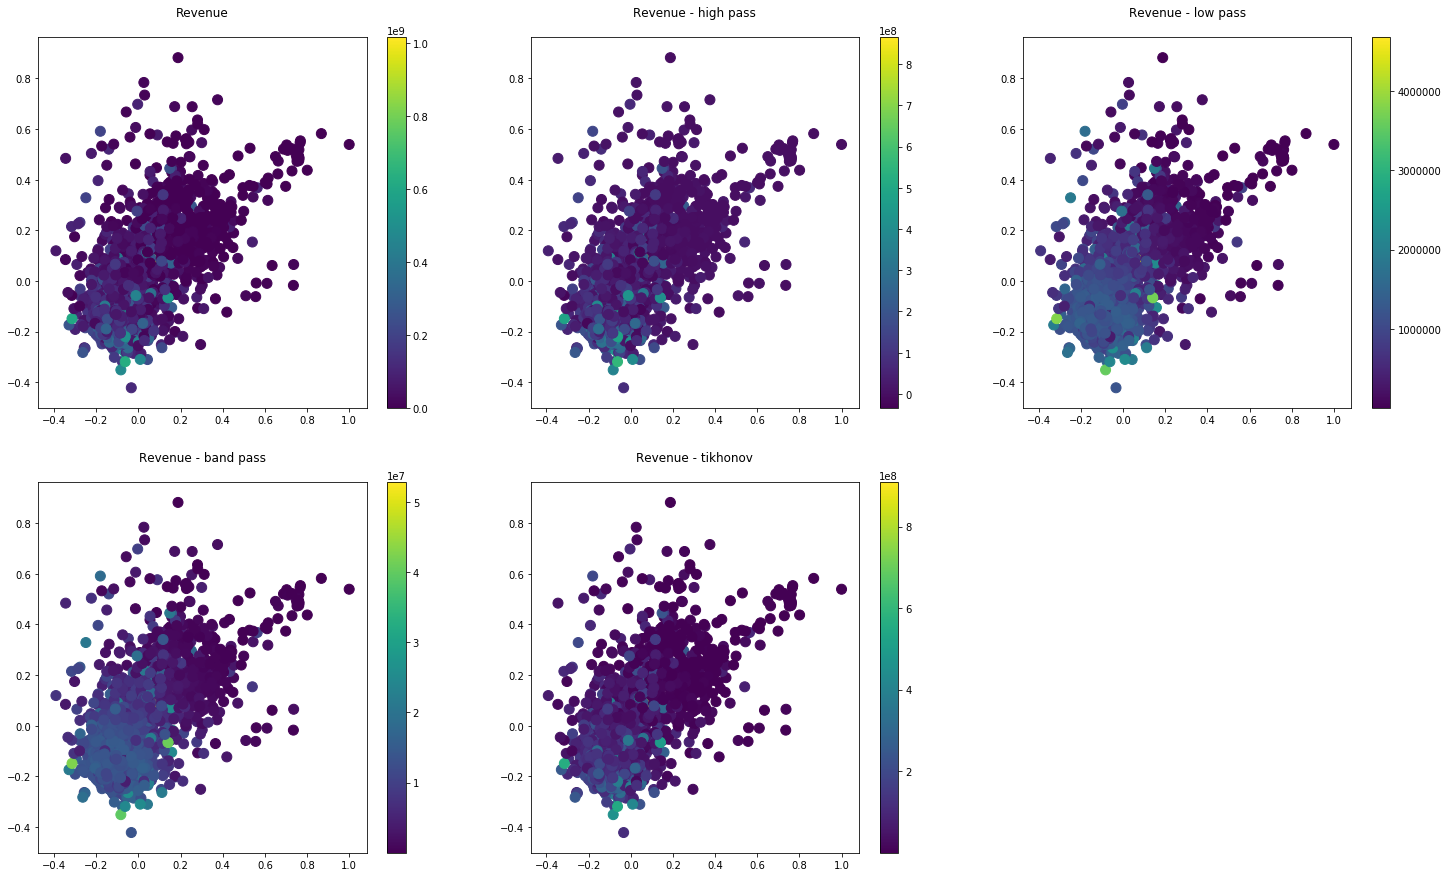

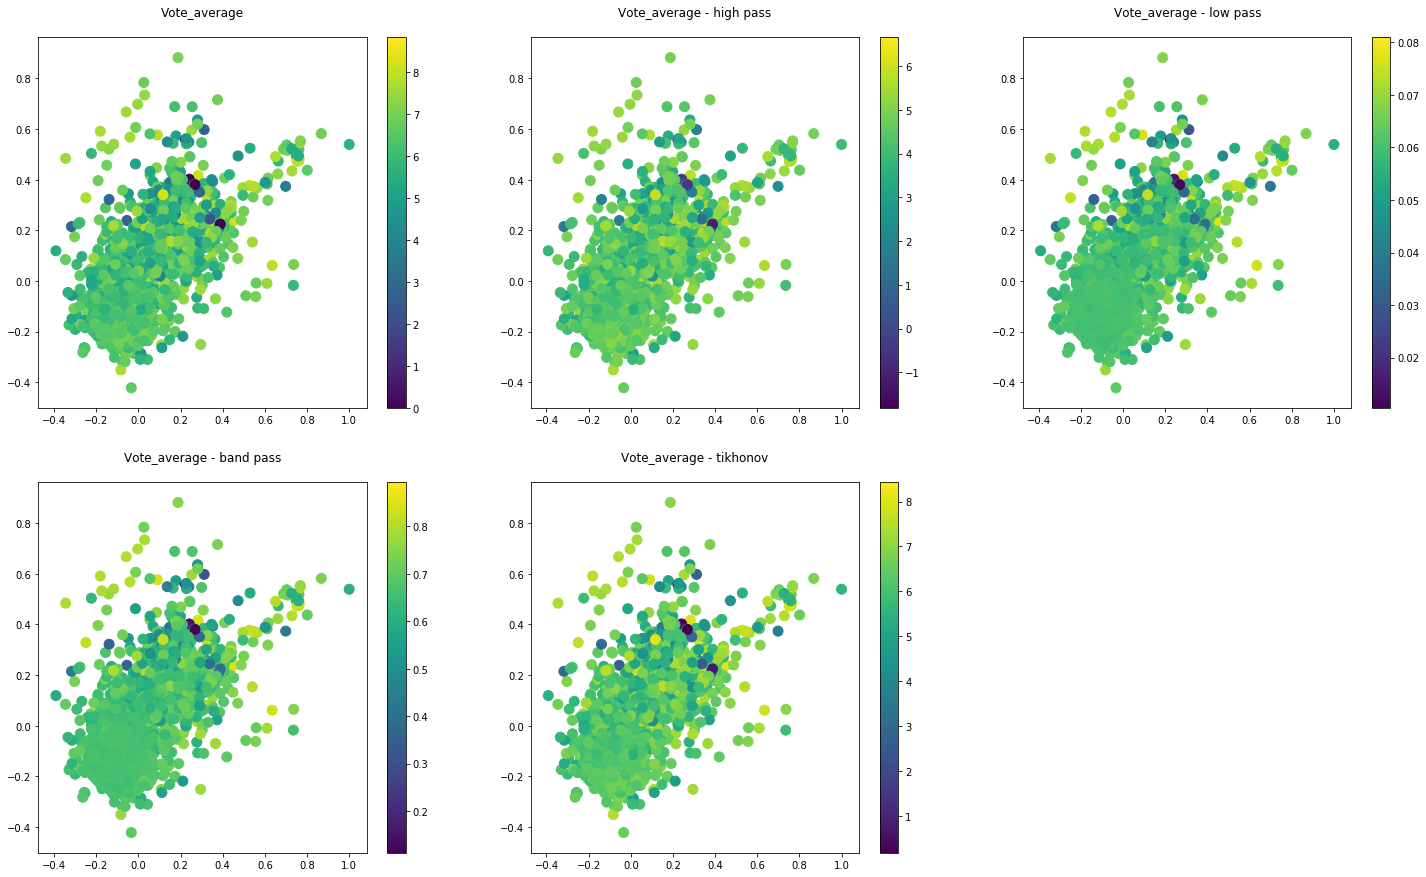

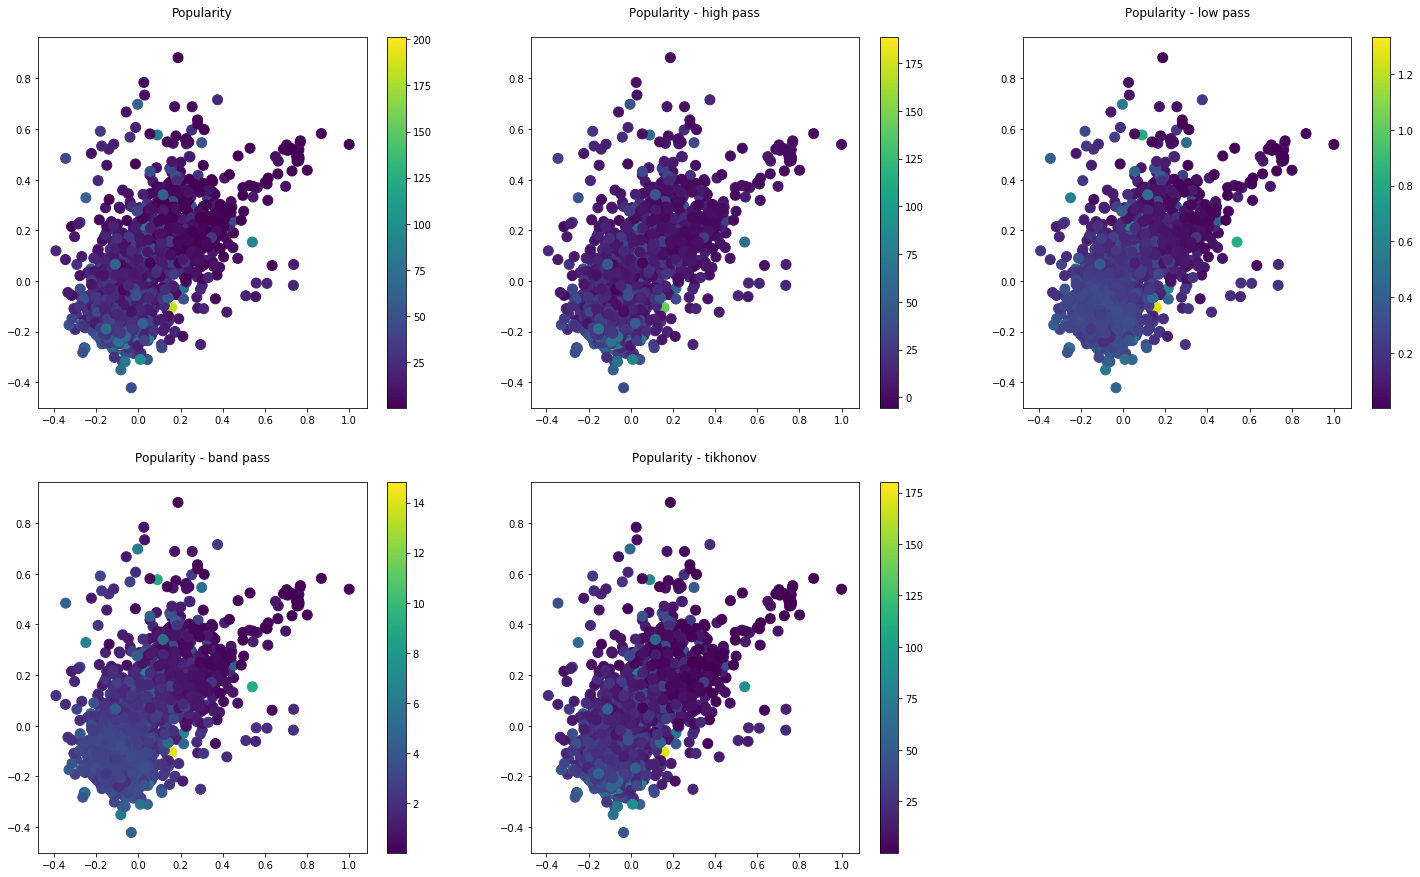

In [12]:
# Graph Images for budget
for col in ["budget", "revenue", "vote_average", "popularity"]:
    data = actors_agg_df[col]
    data_hp = hp_new_df[col]
    data_lp = lp_new_df[col]
    data_bp = bp_new_df[col]
    data_tk = tk_new_df[col]

    fig, ax = plt.subplots(2, 3, figsize=FIGSIZESUB)
    G.plot_signal(data, ax=ax[0, 0], plot_name=f"{col.capitalize()}\n")
    G.plot_signal(data_hp, ax=ax[0, 1] ,plot_name=f"{col.capitalize()} - high pass\n")
    G.plot_signal(data_lp, ax=ax[0, 2] ,plot_name=f"{col.capitalize()} - low pass\n")
    G.plot_signal(data_bp, ax=ax[1, 0] ,plot_name=f"{col.capitalize()} - band pass\n")
    G.plot_signal(data_tk, ax=ax[1, 1] ,plot_name=f"{col.capitalize()} - tikhonov\n")
    fig.delaxes(ax[1, 2])
    plt.savefig(f"plots/{col}_full.pdf")

## Linear regression with filters

In [13]:
cols = ["budget", "revenue", "vote_average", "popularity"]

In [14]:
Xs_hp, Xs_com_hp, ys_hp, ys_com_hp = get_datasets(hp_new_df, cols)
Xs_lp, Xs_com_lp, ys_lp, ys_com_lp = get_datasets(lp_new_df, cols)
Xs_bp, Xs_com_bp, ys_bp, ys_com_bp = get_datasets(bp_new_df, cols)
Xs_tk, Xs_com_tk, ys_tk, ys_com_tk = get_datasets(tk_new_df, cols)

In [15]:
seed = 42

In [16]:
test_size = 0.2

## Highpass

In [17]:
# Worse than vanilla LR
y_budget_pred, budget_nmae, _ = get_linear_reg_results(Xs_hp["budget"],ys_hp["budget"],test_size,seed)
print("Normalized MAE budget: "+str(budget_nmae))

Normalized MAE budget: 0.06299409150343695


In [18]:
# Better than vanilla LR
y_revenue_pred, revenue_nmae, _ = get_linear_reg_results(Xs_hp["revenue"],ys_hp["revenue"],test_size,seed)
print("Normalized MAE revenue: "+str(revenue_nmae))

Normalized MAE revenue: 0.035966442728487154


In [19]:
# Worse than vanilla LR
y_popularity_pred, popularity_nmae, _ = get_linear_reg_results(Xs_hp["popularity"],ys_hp["popularity"],test_size,seed)
print("Normalized MAE popularity: "+str(popularity_nmae))

Normalized MAE popularity: 0.06469265095451282


In [20]:
# Better than vanilla LR
y_popularity_pred, vote_average_nmae, _ = get_linear_reg_results(Xs_hp["vote_average"],ys_hp["vote_average"],test_size,seed)
print("Normalized MAE vote average: "+str(vote_average_nmae))

Normalized MAE vote average: 0.07024360772784996


## Highpass with communities

In [21]:
# Worse than vanilla LR
y_budget_com_pred, budget_com_nmae, _ = get_linear_reg_results(Xs_com_hp["budget"],ys_com_hp["budget"],test_size,seed)
print("Normalized MAE budget: "+str(budget_com_nmae))

Normalized MAE budget: 0.05943568221073721


In [22]:
# Better than vanilla LR
y_revenue_com_pred, revenue_com_nmae, _ = get_linear_reg_results(Xs_com_hp["revenue"],ys_com_hp["revenue"],test_size,seed)
print("Normalized MAE revenue: "+str(revenue_com_nmae))

Normalized MAE revenue: 0.03574397122096778


In [23]:
# Worse than vanilla LR
y_popularity_com_pred, popularity_com_nmae, _ = get_linear_reg_results(Xs_com_hp["popularity"],ys_com_hp["popularity"],test_size,seed)
print("Normalized MAE popularity: "+str(popularity_com_nmae))

Normalized MAE popularity: 0.06403307385913871


In [24]:
# Better than vanilla LR
y_vote_average_com_pred, vote_average_com_nmae, _ = get_linear_reg_results(Xs_com_hp["vote_average"],ys_com_hp["vote_average"],test_size,seed)
print("Normalized MAE vote average: "+str(vote_average_com_nmae))

Normalized MAE vote average: 0.07010986817187642


## Low pass

In [25]:
# Better than vanilla LR
y_budget_pred, budget_com_nmae, _ = get_linear_reg_results(Xs_lp["budget"],ys_lp["budget"],test_size,seed)
print("Normalized MAE budget: "+str(budget_com_nmae))

Normalized MAE budget: 0.030216942710607805


In [26]:
# Better than vanilla LR
y_revenue_pred, revenue_nmae, _ = get_linear_reg_results(Xs_lp["revenue"],ys_lp["revenue"],test_size,seed)
print("Normalized MAE revenue: "+str(revenue_nmae))

Normalized MAE revenue: 0.020584757901004846


In [27]:
# Worse than vanilla LR
y_popularity_pred, popularity_nmae, _ = get_linear_reg_results(Xs_lp["popularity"],ys_lp["popularity"],test_size,seed)
print("Normalized MAE popularity: "+str(popularity_nmae))

Normalized MAE popularity: 0.043734962789382756


In [28]:
# Better than vanilla LR
y_vote_average_pred, vote_average_nmae, _ = get_linear_reg_results(Xs_lp["vote_average"],ys_lp["vote_average"],test_size,seed)
print("Normalized MAE vote average: "+str(vote_average_nmae))

Normalized MAE vote average: 0.0333961655750106


## Low pass with communities

In [29]:
# Better than vanilla LR
y_budget_com_pred, budget_com_nmae, _ = get_linear_reg_results(Xs_com_lp["budget"],ys_com_lp["budget"],test_size,seed)
print("Normalized MAE budget: "+str(budget_com_nmae))

Normalized MAE budget: 0.029669456234493574


In [30]:
# Better than vanilla LR
y_revenue_com_pred, revenue_com_nmae, _ = get_linear_reg_results(Xs_com_lp["revenue"],ys_com_lp["revenue"],test_size,seed)
print("Normalized MAE revenue: "+str(revenue_com_nmae))

Normalized MAE revenue: 0.020586983665552002


In [31]:
# Worse than vanilla LR
y_popularity_com_pred, popularity_com_nmae, _ = get_linear_reg_results(Xs_com_lp["popularity"],ys_com_lp["popularity"],test_size,seed)
print("Normalized MAE popularity: "+str(popularity_com_nmae))

Normalized MAE popularity: 0.043101296065348474


In [32]:
# Better than vanilla LR
y_vote_average_com_pred, vote_average_com_nmae, _ = get_linear_reg_results(Xs_com_lp["vote_average"],ys_com_lp["vote_average"],test_size,seed)
print("Normalized MAE vote average: "+str(vote_average_com_nmae))

Normalized MAE vote average: 0.033365961639028434


## Band pass

In [33]:
# Better than vanilla LR
y_budget_pred, budget_nmae, _ = get_linear_reg_results(Xs_bp["budget"],ys_bp["budget"],test_size,seed)
print("Normalized MAE budget: "+str(budget_nmae))

Normalized MAE budget: 0.029864704534328112


In [34]:
# Better than vanilla LR
y_revenue_pred, revenue_nmae, _ = get_linear_reg_results(Xs_bp["revenue"],ys_bp["revenue"],test_size,seed)
print("Normalized MAE revenue: "+str(revenue_nmae))

Normalized MAE revenue: 0.01987095245279338


In [35]:
# Worse than vanilla LR
y_popularity_pred,popularity_nmae, _ = get_linear_reg_results(Xs_bp["popularity"],ys_bp["popularity"],test_size,seed)
print("Normalized MAE popularity: "+str(popularity_nmae))

Normalized MAE popularity: 0.04319556162306395


In [36]:
# Better than vanilla LR
y_vote_average_pred,vote_average_nmae, _ = get_linear_reg_results(Xs_bp["vote_average"],ys_bp["vote_average"],test_size,seed)
print("Normalized MAE vote_average: "+str(vote_average_nmae))

Normalized MAE vote_average: 0.03334202093186085


## Band pass with communities

In [37]:
# Better than vanilla LR
y_budget_com_pred, budget_com_nmae, _ = get_linear_reg_results(Xs_com_bp["budget"],ys_com_bp["budget"],test_size,seed)
print("Normalized MAE budget: "+str(budget_com_nmae))

Normalized MAE budget: 0.029260396267064514


In [38]:
# Better than vanilla LR
y_revenue_com_pred, revenue_com_nmae, _ = get_linear_reg_results(Xs_com_bp["revenue"],ys_com_bp["revenue"],test_size,seed)
print("Normalized MAE revenue: "+str(revenue_com_nmae))

Normalized MAE revenue: 0.01987131722557088


In [39]:
# Better than vanilla LR
y_popularity_com_pred, popularity_com_nmae, _ = get_linear_reg_results(Xs_com_bp["popularity"],ys_com_bp["popularity"],test_size,seed)
print("Normalized MAE popularity: "+str(popularity_com_nmae))

Normalized MAE popularity: 0.04260493732476338


In [40]:
# Better than vanilla LR
y_vote_average_com_pred, vote_average_com_nmae, _ = get_linear_reg_results(Xs_com_bp["vote_average"],ys_com_bp["vote_average"],test_size,seed)
print("Normalized MAE vote average: "+str(vote_average_com_nmae))

Normalized MAE vote average: 0.033320927710053044


## Tikhonov

In [41]:
# Better than vanilla LR
y_budget_pred, budget_nmae, _ = get_linear_reg_results(Xs_tk["budget"],ys_tk["budget"],test_size,seed)
print("Normalized MAE budget: "+str(budget_nmae))

Normalized MAE budget: 0.05046659069286351


In [42]:
# Better than vanilla LR
y_revenue_pred, revenue_nmae, _ = get_linear_reg_results(Xs_tk["revenue"],ys_tk["revenue"],test_size,seed)
print("Normalized MAE revenue: "+str(revenue_nmae))

Normalized MAE revenue: 0.028305018876426714


In [43]:
# Worse than vanilla LR
y_popularity_pred,popularity_nmae, _ = get_linear_reg_results(Xs_tk["popularity"],ys_tk["popularity"],test_size,seed)
print("Normalized MAE popularity: "+str(popularity_nmae))

Normalized MAE popularity: 0.06069344352020804


In [44]:
# Better than vanilla LR
y_vote_average_pred, vote_average_nmae, _ = get_linear_reg_results(Xs_tk["vote_average"],ys_tk["vote_average"],test_size,seed)
print("Normalized MAE vote average: "+str(vote_average_com_nmae))

Normalized MAE vote average: 0.033320927710053044


## Tikhonov with communities

In [45]:
# Better than vanilla LR
y_budget_com_pred, budget_com_nmae, _ = get_linear_reg_results(Xs_com_tk["budget"],ys_com_tk["budget"],test_size,seed)
print("Normalized MAE budget: "+str(budget_com_nmae))

Normalized MAE budget: 0.04743841062635868


In [46]:
# Better than vanilla LR
y_revenue_com_pred, revenue_com_nmae, _ = get_linear_reg_results(Xs_com_tk["revenue"],ys_com_tk["revenue"],test_size,seed)
print("Normalized MAE revenue: "+str(revenue_com_nmae))

Normalized MAE revenue: 0.02828173220257606


In [47]:
# Worse than vanilla LR
y_popularity_com_pred, popularity_com_nmae, _ = get_linear_reg_results(Xs_com_tk["popularity"],ys_com_tk["popularity"],test_size,seed)
print("Normalized MAE popularity: "+str(popularity_com_nmae))

Normalized MAE popularity: 0.05985460215436497


In [48]:
# Better than vanilla LR
y_vote_average_com_pred, vote_average_com_nmae, _ = get_linear_reg_results(Xs_com_tk["vote_average"],ys_com_tk["vote_average"],test_size,seed)
print("Normalized MAE vote average: "+str(vote_average_com_nmae))

Normalized MAE vote average: 0.052067764696698444
